## Install packages

In [1]:
# # install packages in following order
# !pip install pandas
# !pip install spacy
# !python -m spacy download en_core_web_trf
# !python -m spacy download en_core_web_sm
# !pip install crosslingual-coreference
# !pip install ipywidgets
# !pip uninstall torch
# !conda install pytorch torchvision torchaudio cudatoolkit=11.6 -c pytorch -c conda-forge
# !pip install spacyfishing

In [2]:
import spacy
import crosslingual_coreference
import pandas as pd

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\GCM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import Data

Data was obtained by exporting a csv from scopus. This includes abstracts of all articles.

In [3]:
# import data
data_df = pd.read_csv('E:\GIT_REPOS\LAB\Literature_summary\Papers\\scopus_bark_ambrosia_beetles.csv')

## Coreference resolution

In [4]:
# crosslingual_coreference implementation
nlp = spacy.load('en_core_web_trf')
nlp.add_pipe("xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": 0})

def coref_res(text_series):
    coref_text_series = text_series.apply(lambda x : nlp(x)._.resolved_text)
    return(coref_text_series)

# # choose minilm for speed/memory and info_xlm for accuracy
# predictor = Predictor(
#     language="en_core_web_sm", device=-1, model_name="minilm"
# )

error loading _jsonnet (this is expected on Windows), treating C:\Users\GCM\AppData\Local\Temp\tmpr2dr5je7\config.json as plain json
Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large and 

In [5]:
coref_df = pd.DataFrame(coref_res(text_series=data_df["Abstract"][:10]))

## Entity labelling

In [6]:
nlp_model_en = spacy.load("en_core_web_trf")
nlp_model_en.add_pipe("entityfishing")

def link_entities_text(text):
    text_entities = nlp_model_en(text)
    entity_df = pd.DataFrame()
    text_lst = []
    label_lst = []
    kb_qid_lst = []
    url_wikidata = []
    nerd_score = []
    for entity in text_entities.ents:
        text_lst.append(entity.text)
        label_lst.append(entity.label_)
        kb_qid_lst.append(entity._.kb_qid)
        url_wikidata.append(entity._.url_wikidata)
        nerd_score.append(entity._.nerd_score)
    entity_df['text'] = text_lst
    entity_df['label'] = label_lst
    entity_df['kb_qid'] = kb_qid_lst
    entity_df['url_wikidata'] = url_wikidata
    entity_df['nerd_score'] = nerd_score
    return(entity_df)

def link_entities(text_series):
    entity_df_series = text_series.apply(lambda x : link_entities_text(x))
    return(entity_df_series)

In [7]:
entity_df_lst = link_entities(text_series = coref_df['Abstract']).tolist()
all_entities_df = pd.concat(entity_df_lst).reset_index(drop=True)

In [8]:
# clean entities
all_entities_df.sort_values(by='nerd_score',ascending=False, inplace=True)
all_entities_df = all_entities_df[all_entities_df['kb_qid'].notna()].reset_index(drop=True)

In [9]:
all_entities_df['label'].unique()

array(['GPE', 'ORG', 'LOC', 'NORP', 'DATE', 'CARDINAL'], dtype=object)

In [21]:
count_entities_df = all_entities_df[['kb_qid', 'text', 'label', 'url_wikidata']]
count_entities_df['count'] = 1
count_entities_df = count_entities_df.groupby(['kb_qid', 'text', 'label', 'url_wikidata'], as_index=False).count()
count_entities_df = count_entities_df.sort_values('count', ascending=False).reset_index(drop=True)

<AxesSubplot: >

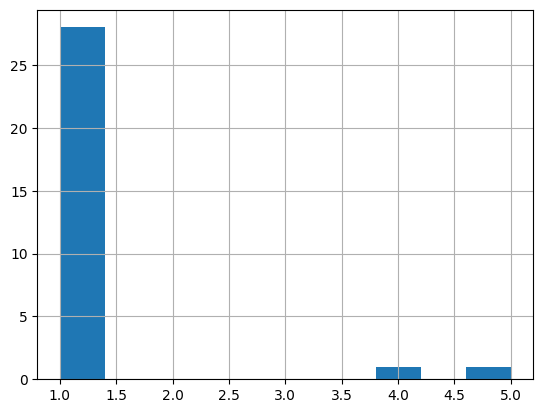

In [22]:
count_entities_df['count'].hist()

In [24]:
count_entities_df[~count_entities_df['label'].isin(['DATE', 'CARDINAL'])].reset_index(drop=True)

,kb_qid,text,label,url_wikidata,count
0,Q148,China,GPE,https://www.wikidata.org/wiki/Q148,4
1,Q42824,Mato Grosso,GPE,https://www.wikidata.org/wiki/Q42824,1
2,Q7850,Chinese,NORP,https://www.wikidata.org/wiki/Q7850,1
3,Q746413,Elsevier B.V.,ORG,https://www.wikidata.org/wiki/Q746413,1
4,Q49,North American,NORP,https://www.wikidata.org/wiki/Q49,1
5,Q49,North America,LOC,https://www.wikidata.org/wiki/Q49,1
6,Q433574,Alta Floresta,GPE,https://www.wikidata.org/wiki/Q433574,1
7,Q1255792,Mountain,LOC,https://www.wikidata.org/wiki/Q1255792,1
8,Q2585125,British Society for Plant Pathology,ORG,https://www.wikidata.org/wiki/Q2585125,1
9,Q155,Brazil,GPE,https://www.wikidata.org/wiki/Q155,1


## Entity linking

In [ ]:
import spacy_component

nlp_rebel = spacy.load("en_core_web_trf")

nlp_rebel.add_pipe("rebel", after="senter", config={
    'device':0, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

## Graph construction